# Deep Swirl Tutorial

David John Gagne, National Center for Atmospheric Research

The goal of this tutorial is to demonstrate how deep learning models work using complex weather data. You will train a series of neural networks to predict whether a simulated thunderstorm will develop a strong low-level mesocyclone in the next hour. A mesocyclone is a rotating updraft that is a necessary precursor to the formation of a supercellular tornado. 

In this tutorial, you will learn the following skills:
* How to pre-process data into an appropriate format for deep learning
* How to build and train a dense artificial neural network in Keras
* How to build and train a convolutional neural network in Keras
* What activation and pooling functions to use
* Dropout, batch normalization, and other regularization techniques
* What optimizers and loss functions are appropriate for different problems
* How to evaluate deep learning predictions
* How to interpret deep learning models through variable importance and feature optimization

### Installation Instructions

This tutorial requires the following Python 3.6 libraries:
* numpy
* scipy
* matplotlib
* xarray
* netCDF4-python
* pandas
* pip
* tensorflow or tensorflow-gpu
* keras

If you want to install these libraries on your local machine, the [Miniconda](https://conda.io/miniconda.html) Python package manager is recommended. Please follow the link and instructions to install the appropriate Miniconda for your OS. After Miniconda is installed, either install the packages directly with `conda install` or create a conda environment (bash shell required). Tensorflow with GPU support requires a NVIDIA GPU with CUDA and cuDNN to be installed. Specific installation instructions are beyond the scope of this tutorial, but more information about installing tensorflow can be found [here](https://www.tensorflow.org/install/). The easiest way to get access to a GPU with deep learning capabilities is to use a Deep Learning image on AWS, Google Cloud, or Azure or find an appropriate docker container. To install the necessary libraries without GPU support, please use the following commands:

```bash
conda create --name deep -c conda-forge python=3.6 numpy scipy matplotlib pandas netcdf4 xarray
# Activate the environment
source activate deep
# Install tensorflow and keras from their PyPI binaries
pip install tensorflow
pip install keras
```

## Data Pre-Processing

The storm data for this exercise comes from a series of deterministic 3 km grid spacing WRF-ARW runs performed on major storm event days from 2010 through 2017. A storm-finding algorithm identified strong updrafts in the dataset and extracted a 32x32 grid point (96x96 km) box surrounding each updraft track. The following input variables have been extracted in that area:
* Simulated composite radar reflectivity
* Temperature at 2 m above the surface
* Depoint at 2 m above the surface
* Zonal wind (u-component) at 10 m above the surface
* Meridional wind (v-component) at 10 m above the surface

These variables are what would be available to a forecaster in a real-time severe weather prediction situation.
The prediction field is relative vorticity at 1 km AGL, which was shown to be a good proxy for strong low-level mesocyclones in [Sobash et al. 2016](https://doi.org/10.1175/WAF-D-16-0073.1). The data are stored in a series of netCDF4 files in which each variable contains a stack of storm patches in (patch, y, x) dimensions. 

A 3 GB tar file containing all the data can be downloaded [here](https://drive.google.com/file/d/1tJTrEEoFuup4Ezud57pEYEopqA8Hcw06/view?usp=sharing). Please copy the tar file to your home directory and extract it from there.

First we will import the libraries required for pre-processing.

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import percentileofscore
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, expanduser
import os

To load the storm data into memory, we will loop through each netCDF file and extract the appropriate variables. Keras and tensorflow expect their input data to be arranged into a (example, y, x, variable)-dimensioned array, so we will do so. We will also extract the run times and valid times for each storm, which we will use to separate the training and testing data. 

<span style="color:red">**WARNING**</span>: If you are running this example on your local machine, loading in the data requires about 9 GB of RAM. At least 16 GB of RAM is recommended. If you have a smaller amount of RAM and wish to complete this exercise, remove `"T2_prev"` and `"TD2_prev"` from `in_vars`. You can also load in a smaller number of training examples by filtering the storm files by run date. 

In [2]:
# Create a list of storm netCDF4 files. If the files are not in your home directory,
# Change the start_path variable to the appropriate location
start_path = expanduser("~")
storm_files = sorted(glob(join(start_path, "track_data_ncarstorm_3km_nc_small/*.nc")))
print(storm_files[0])
run_times = []
valid_times = []
# List of input variables
in_vars = ["REFL_COM_prev",
           "T2_prev", "TD2_prev", "U10_prev", "V10_prev"]
# List of output variables
out_vars = ["RVORT1_MAX_curr"]
in_data = []
out_data = []
# Loop through each storm file and extract the relevant variables
for storm_file in storm_files:
    # Extract run time from the filename
    run_time = pd.Timestamp(storm_file.split("/")[-1].split("_")[1])
    # If you want to ignore certain run_dates, encapsulate the remaining lines in an if statement
    ds = xr.open_dataset(storm_file)
    # Stack the variables in the order listed within a given file
    in_data.append(np.stack([ds[v].values for v in in_vars], axis=-1))
    out_data.append(np.stack([ds[v].values for v in out_vars], axis=-1))
    # Extract the valid times
    valid_times.append(ds["time"].values)
    # Extract the run times and match each run time with each patch
    run_times.append([run_time] * in_data[-1].shape[0])
    print(run_time)
    ds.close()
# Stack the  data into single arrays instead of lists of arrays
all_in_data = np.vstack(in_data)
all_out_data = np.vstack(out_data)
all_run_times = np.concatenate(run_times)
all_valid_times = np.concatenate(valid_times)
# Deallocate the lists of arrays to save memory
del in_data[:], out_data[:], run_times[:], valid_times[:]
del in_data, out_data, run_times, valid_times

/home/ubuntu/track_data_ncarstorm_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc
2010-10-24 00:00:00
2010-10-25 00:00:00
2010-10-26 00:00:00
2010-10-27 00:00:00
2010-11-16 00:00:00
2010-11-22 00:00:00
2010-11-29 00:00:00
2010-11-30 00:00:00
2010-12-31 00:00:00
2011-01-25 00:00:00
2011-02-01 00:00:00
2011-02-24 00:00:00
2011-02-27 00:00:00
2011-02-28 00:00:00
2011-03-05 00:00:00
2011-03-08 00:00:00
2011-03-09 00:00:00
2011-03-10 00:00:00
2011-03-22 00:00:00
2011-03-23 00:00:00
2011-03-26 00:00:00
2011-03-27 00:00:00
2011-03-29 00:00:00
2011-03-31 00:00:00
2011-04-03 00:00:00
2011-04-04 00:00:00
2011-04-08 00:00:00
2011-04-09 00:00:00
2011-04-10 00:00:00
2011-04-11 00:00:00
2011-04-14 00:00:00
2011-04-15 00:00:00
2011-04-16 00:00:00
2011-04-18 00:00:00
2011-04-19 00:00:00
2011-04-20 00:00:00
2011-04-21 00:00:00
2011-04-22 00:00:00
2011-04-23 00:00:00
2011-04-24 00:00:00
2011-04-25 00:00:00
2011-04-26 00:00:00
2011-04-27 00:00:00
2011-04-28 00:00:00
2011-04-30 00:00:00
2011-05-

2016-03-30 00:00:00
2016-03-31 00:00:00
2016-04-01 00:00:00
2016-04-06 00:00:00
2016-04-07 00:00:00
2016-04-10 00:00:00
2016-04-11 00:00:00
2016-04-15 00:00:00
2016-04-24 00:00:00
2016-04-26 00:00:00
2016-04-27 00:00:00
2016-04-28 00:00:00
2016-04-29 00:00:00
2016-05-01 00:00:00
2016-05-02 00:00:00
2016-05-03 00:00:00
2016-05-04 00:00:00
2016-05-05 00:00:00
2016-05-07 00:00:00
2016-05-08 00:00:00
2016-05-09 00:00:00
2016-05-10 00:00:00
2016-05-11 00:00:00
2016-05-12 00:00:00
2016-05-16 00:00:00
2016-05-17 00:00:00
2016-05-21 00:00:00
2016-05-22 00:00:00
2016-05-24 00:00:00
2016-05-25 00:00:00
2016-05-26 00:00:00
2016-05-27 00:00:00
2016-05-28 00:00:00
2016-05-29 00:00:00
2016-05-31 00:00:00
2016-06-02 00:00:00
2016-06-05 00:00:00
2016-06-08 00:00:00
2016-06-10 00:00:00
2016-06-13 00:00:00
2016-06-14 00:00:00
2016-06-15 00:00:00
2016-06-16 00:00:00
2016-06-17 00:00:00
2016-06-19 00:00:00
2016-06-20 00:00:00
2016-06-21 00:00:00
2016-06-22 00:00:00
2016-06-23 00:00:00
2016-06-24 00:00:00


Our label will be based on the maximum relative vorticity observed over the hour following the storm data collected.
We will be making a probabilistic prediction of whether the maximum relative vorticity exceeds a specific threshold. For this tutorial, I picked a threshold of 0.008 1/s, which roughly corresponds to the 90th percentile in the dataset. 

In [5]:
max_vort = all_out_data[:, :, :, 0].max(axis=-1).max(axis=-1)
vort_thresh = 0.008
print(percentileofscore(max_vort, vort_thresh))
vort_labels = np.where(max_vort > vort_thresh, 1, 0)

90.4781920253


Text(0,0.5,'Cumulative Distribution')

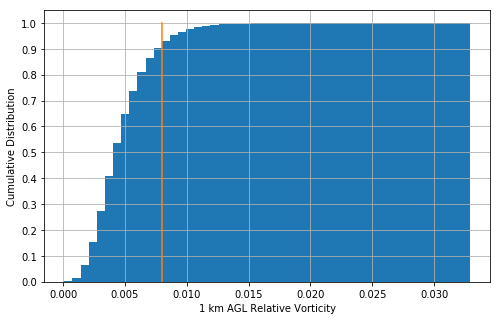

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(max_vort, bins=50, cumulative=True, normed=True)
plt.plot(np.ones(10) * vort_thresh, np.linspace(0, 1, 10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.xlabel("1 km AGL Relative Vorticity")
plt.ylabel("Cumulative Distribution")

Neural networks tend to converge more quickly if the input data are rescaled to be centered around 0. We will use normalization to perform the scaling for each variable separately. One could also re-scale the data to range from -1 to 1 or scale based on the median and IQR instead of the mean and standard deviation.

In [7]:
def normalize_multivariate_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
    for i in range(data.shape[-1]):
        scaling_values.loc[i, ["mean", "std"]] = [data[:, :, :, i].mean(), data[:, :, :, i].std()]
        normed_data[:, :, :, i] = (data[:, :, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values

In [8]:
norm_in_data, scaling_values = normalize_multivariate_data(all_in_data)

Our data exhibit spatial and temporal correlation, so randomly splitting data examples into training and test sets may result in information leakage. To avoid that problem, we split the data based on the model run initialization time.

In [9]:
split_date = pd.Timestamp("2015-01-01")
train_indices = np.where(all_run_times < split_date)[0]
test_indices = np.where(all_run_times >= split_date)[0]

## Deep Neural Networks

Now we will start building deep learning models using the keras library. Keras is a high-level API to Tensorflow and other large deep learning/tensor math libraries. Keras makes it really easy to build neural network architectures of arbitrary complexity and then train them on GPUs and CPUs with a few functional calls. 

Keras models consist of a series of layers connected in a directed acyclic graph. Neural networks can have multiple inputs and outputs but most have one input and one output layer. 

Now we will import all of the necessary keras components for our exercises.

In [10]:
from keras.models import Model
from keras.layers import Dense, Activation, Conv2D, Input, AveragePooling2D, Flatten, LeakyReLU
from keras.optimizers import SGD, Adam
import keras.backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot



Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Each neural network hidden layer consists of a set of articifial neurons that aggregate values from the previous layer into a weighted sum. That sum is then transformed with a nonlinear activation that acts as a filter. 

Common activation functions are plotted below. Classical ANNs used a sigmoid or hyperbolic tangent (tanh) activation function to mimic the activation of neurons in the brain. The problem with sigmoids, and to a lesser extent with tanh, is that when error information is backpropagated through the network, the maximum gradient (derivative of input with respect to change in output) of the sigmoid is around 0.3, so each backward pass through a sigmoid reduces the magnitude of the gradient by 70% or more. This leads to the "vanishing gradient problem" for deep neural networks. After 2 or 3 layers the magnitude of the gradient is too small to provide a consistent signal about how the weights should be updated, resulting in poor convergence of the model.

The Rectifed Linear Unit (ReLU) activation solves this issue by performing a transform such that positive values retain their original magnitude while negative values are set to 0. Because the magnitude of the positive gradient does not decrease, the gradient signal can be propagated through many layers without vanishing. Zeroing out the negative gradient can sometimes lead to dead neurons, so variants of the ReLU, such as the Leaky ReLU and the Exponential Linear Unit (ELU) have been created to propagate negative information but at a reduced magnitude.

Text(0.5,1,'ANN Activation Gradients')

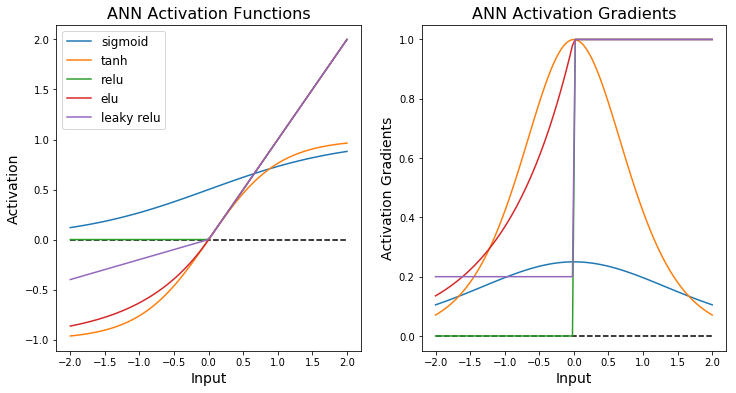

In [11]:
# Placeholder input tensor allows for numpy arrays to be fed through the function into Tensorflow
act_in = K.placeholder()
# List of activations
activations = ["sigmoid", "tanh", "relu", "elu"]
act_funcs = []
in_vals = np.linspace(-2, 2, 100)
out_vals = []
plt.figure(figsize=(12, 6))
# Plot each activation function
plt.subplot(1, 2, 1)
plt.plot(in_vals, np.zeros(in_vals.shape), 'k--')
for act in activations:
    # K.function creates a general input-output function between 2 connected keras tensors
    act_funcs.append(K.function([act_in], [Activation(act)(act_in)]))
    out_vals.append(act_funcs[-1]([in_vals])[0])
    plt.plot(in_vals, out_vals[-1], label=act)
act_funcs.append(K.function([act_in], [LeakyReLU(0.2)(act_in)]))
out_vals.append(act_funcs[-1]([in_vals])[0])
plt.plot(in_vals, out_vals[-1], label="leaky relu")
plt.xlabel("Input", fontsize=14)
plt.ylabel("Activation", fontsize=14)
plt.title("ANN Activation Functions", fontsize=16)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
# Plot the gradients of each activation function
plt.plot(in_vals, np.zeros(in_vals.shape), 'k--')
for act in activations:
    # K.gradients calculates the gradient between an arbitrary input and output pairing
    act_funcs.append(K.function([act_in], K.gradients(Activation(act)(act_in), act_in)))
    out_vals.append(act_funcs[-1]([in_vals])[0])
    plt.plot(in_vals, out_vals[-1], label=act)
act_funcs.append(K.function([act_in], K.gradients(LeakyReLU(0.2)(act_in), act_in)))
out_vals.append(act_funcs[-1]([in_vals])[0])
plt.plot(in_vals, out_vals[-1], label="leaky relu")
plt.xlabel("Input", fontsize=14)
plt.ylabel("Activation Gradients", fontsize=14)
plt.title("ANN Activation Gradients", fontsize=16)


First we will build a dense neural network with Keras using the Model API. 

In [13]:
# Input layer
dense_in = Input(shape=all_in_data.shape[1:])
# Flatten input layer into long vector
dense = Flatten()(dense_in)
# First hidden layer
dense = Dense(64)(dense)
# Activation function for first hidden layer
dense = Activation("relu")(dense)
# Second Hidden layer
dense = Dense(64)(dense)
dense = Activation("relu")(dense)
# Output layer
dense = Dense(1)(dense)
dense = Activation("sigmoid")(dense)
# Creates a model object that links input layer and output
dense_model = Model(dense_in, dense)
# Optimizer object
opt_dense = SGD(lr=0.001, momentum=0.99, decay=1e-4, nesterov=True)
# Compile model with optimizer and loss function
dense_model.compile(opt_dense, "mse")

An Optimizer controls how the model weights are updated. Two popular optimizers in Keras are SGD and Adam. Neural networks are generally optimized through the process of gradient descent, in which the values of network weights $\theta$ are updated based on the gradient of the loss function:

$\hat{g}=\frac{1}{m}\nabla_{\theta}\sum L(f(x;\theta), y)$

$\theta=\theta-\epsilon \hat{g}$.

The size of the update is controlled by the learning rate $\epsilon$. A larger learning rate results in faster convergence, but too large a learning rate can cause the optimizer to overshoot the global minimum. If the learning rate is too small, the optimizer can get trapped in a local minimum or just never converge. Specialized optimizer functions have been developed to address some of these issues.

SGD: Stochastic Gradient Descent. The stochastic component comes from selecting a random "batch" of training examples for each update. SGD includes an option to add momentum to the gradient descent update, which allows the optimizer to retain a memory of what the previous gradients were to reduce the variance in stochastic gradient computations. A high momentum value around 0.99 is generally recommended in practice.

Adam: Short for "adaptive moments." This optimizer automatically updates the learning rate based on the first and second moments of the gradient. 

In [14]:
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 5)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                327744    
_________________________________________________________________
activation_12 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_13 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
__________

Now we train the dense model for 10 epochs (passes through the training data) with a batch size of 128 examples.

In [17]:
dense_hist = dense_model.fit(norm_in_data[train_indices], 
                             vort_labels[train_indices], 
                             batch_size=128, epochs=10, verbose=2)

Epoch 1/10
 - 4s - loss: 0.0826
Epoch 2/10
 - 4s - loss: 0.0703
Epoch 3/10
 - 4s - loss: 0.0672
Epoch 4/10
 - 4s - loss: 0.0650
Epoch 5/10
 - 4s - loss: 0.0634
Epoch 6/10
 - 4s - loss: 0.0621
Epoch 7/10
 - 4s - loss: 0.0612
Epoch 8/10
 - 4s - loss: 0.0601
Epoch 9/10
 - 4s - loss: 0.0591
Epoch 10/10
 - 4s - loss: 0.0580


Next we build a convolutional neural network to predict the probability of a mesocyclone.

In [18]:
# Input data in shape (y, x, variable)
conv_net_in = Input(shape=all_in_data.shape[1:])
# First 2D convolution Layer
conv_net = Conv2D(8, (5, 5), padding="same")(conv_net_in)
conv_net = Activation("relu")(conv_net)
# Average pooling takes the mean in a 2x2 neighborhood to reduce the image size
conv_net = AveragePooling2D()(conv_net)
# Second set of convolution and pooling layers
conv_net = Conv2D(16, (5, 5), padding="same")(conv_net)
conv_net = Activation("relu")(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Third set of convolution and pooling layers
conv_net = Conv2D(24, (5, 5), padding="same")(conv_net)
conv_net = Activation("relu")(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Flatten the last convolutional layer into a long feature vector
conv_net = Flatten()(conv_net)
# Dense output layer, equivalent to a logistic regression on the last layer
conv_net = Dense(1)(conv_net)
conv_net = Activation("sigmoid")(conv_net)
conv_model = Model(conv_net_in, conv_net)
# Use the Adam optimizer with default parameters
opt = Adam()
conv_model.compile(opt, "mse")

In [19]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         1008      
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        3216      
_________________________________________________________________
activation_16 (Activation)   (None, 16, 16, 16)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 16)          0         
__________

In [20]:
conv_hist = conv_model.fit(norm_in_data[train_indices], vort_labels[train_indices], 
                           batch_size=128, epochs=10, verbose=2)

Epoch 1/10
 - 11s - loss: 0.0855
Epoch 2/10
 - 9s - loss: 0.0669
Epoch 3/10
 - 9s - loss: 0.0597
Epoch 4/10
 - 9s - loss: 0.0561
Epoch 5/10
 - 9s - loss: 0.0543
Epoch 6/10
 - 9s - loss: 0.0529
Epoch 7/10
 - 9s - loss: 0.0524
Epoch 8/10
 - 9s - loss: 0.0517
Epoch 9/10
 - 9s - loss: 0.0507
Epoch 10/10
 - 9s - loss: 0.0501


In [21]:
dense_preds = dense_model.predict(norm_in_data[test_indices])[:, 0]
conv_preds = conv_model.predict(norm_in_data[test_indices])[:, 0]


In [22]:
def brier_score(obs, pred):
    return np.mean((pred - obs) ** 2)

def brier_skill_score(obs, pred):
    return 1 - brier_score(obs, pred) / obs.mean()

conv_bss = brier_skill_score(vort_labels[test_indices], conv_preds)
dense_bss = brier_skill_score(vort_labels[test_indices], dense_preds)

print(conv_bss, dense_bss)

0.428220023649 0.281750850158


## Model Interpretation

One of the common critiques of machine learning models is that many appear to be a "black box", in which predictions are made without associated reasoning why they were made. However, there are ways to interrogate machine learning models to extract information about how the model weights each input and how the model encodes information internally. 

Permutation variable importance is a model-agnostic way of estimating how much each input affects the prediction values on average. In permutation variable importance, a metric is calculated on the model predictions of the validation data. Then each validation set input is permuted, or shuffled, among the examples, and the metric is recalculated. A large change in the metric value corresponds with higher importance for that input. 

In [23]:
def variable_importance(model, data, labels, input_vars, score_func, num_iters=10):
    preds = model.predict(data)[:, 0]
    score_val = score_func(labels, preds)
    indices = np.arange(data.shape[0])
    imp_scores = np.zeros((len(input_vars), num_iters))
    shuf_data = np.copy(data)
    for n in range(num_iters):
        print(n)
        np.random.shuffle(indices)
        for v, var in enumerate(input_vars):
            print(var)
            shuf_data[:, :, :, v] = shuf_data[indices, :, :, v]
            shuf_preds = model.predict(shuf_data)[:, 0]
            imp_scores[v, n] = score_func(labels, shuf_preds)
            shuf_data[:, :, :, v] = data[:, :, :, v]
    return score_val - imp_scores

In [24]:
conv_imp_scores = variable_importance(conv_model, norm_in_data[test_indices], 
                                       vort_labels[test_indices], in_vars, brier_skill_score, num_iters=3)

0
REFL_COM_prev
T2_prev
TD2_prev
U10_prev
V10_prev
1
REFL_COM_prev
T2_prev
TD2_prev
U10_prev
V10_prev
2
REFL_COM_prev
T2_prev
TD2_prev
U10_prev
V10_prev


In [25]:
dense_imp_scores = variable_importance(dense_model, norm_in_data[test_indices], 
                                       vort_labels[test_indices], in_vars, brier_skill_score, num_iters=3)

0
REFL_COM_prev
T2_prev
TD2_prev
U10_prev
V10_prev
1
REFL_COM_prev
T2_prev
TD2_prev
U10_prev
V10_prev
2
REFL_COM_prev
T2_prev
TD2_prev
U10_prev
V10_prev


In [39]:
dense_mean_scores = dense_imp_scores.mean(axis=1)
conv_mean_scores = conv_imp_scores.mean(axis=1)
for v, var in enumerate(in_vars):
    print(var, dense_mean_scores[v], conv_mean_scores[v])

REFL_COM_prev 0.208490946685 0.230143110763
T2_prev 0.091117403005 0.0298855942669
TD2_prev 0.0908222329723 0.0461585912804
U10_prev 0.131786501472 0.184827824902
V10_prev 0.107750055429 0.247659171935


We can visualize what input most activates the output layer of the network through feature optimization. Example code is shown below.

In [36]:
out_diff = K.mean((conv_model.layers[-1].output - 1) ** 2)
grad = K.gradients(out_diff, [conv_model.input])[0]
grad /= K.maximum(K.sqrt(K.mean(grad ** 2)), K.epsilon())
iterate = K.function([conv_model.input, K.learning_phase()], 
                         [out_diff, grad])
input_img_data = np.random.normal(scale=0.1, size=(1, 32, 32, len(in_vars)))
for i in range(50):
    out_loss, out_grad = iterate([input_img_data, 0])
    input_img_data -= out_grad * 0.01
    print(out_loss)

0.946165
0.929551
0.915758
0.900276
0.88458
0.866948
0.853606
0.831646
0.808038
0.789069
0.767126
0.742777
0.719074
0.699606
0.677565
0.649819
0.626937
0.604244
0.573704
0.540236
0.504007
0.467868
0.435126
0.411647
0.386423
0.352225
0.311141
0.278275
0.252467
0.216136
0.189
0.156333
0.13611
0.111326
0.0912397
0.0657573
0.0496869
0.0355596
0.0261732
0.017399
0.0125667
0.00776841
0.00484617
0.00302794
0.00193041
0.00114701
0.000772404
0.000468989
0.000283089
0.000181656


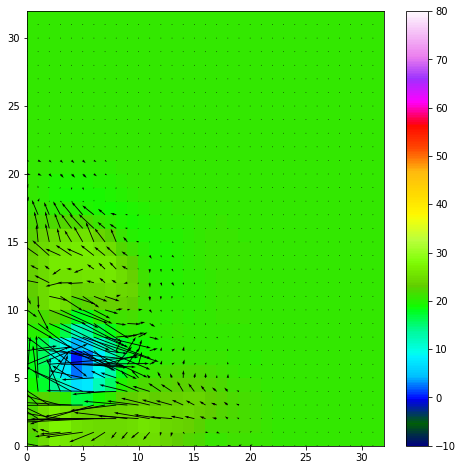

In [98]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(input_img_data[0, :, :, 0] * scaling_values.loc[0, "std"] + scaling_values.loc[0, "mean"], 
               vmin=-10, vmax=80, cmap="gist_ncar")
#plt.contour(input_img_data[0, :, :, 1], cmap="Reds")
#plt.contour(input_img_data[0, :, :, 2], cmap="Blues")

#plt.contour(gaussian_filter(input_img_data[0, :, :, 3], 1), vmin=-4, vmax=4, cmap="Greens")
plt.colorbar()
plt.quiver(input_img_data[0, :, :, 3], input_img_data[0, :, :, 4])

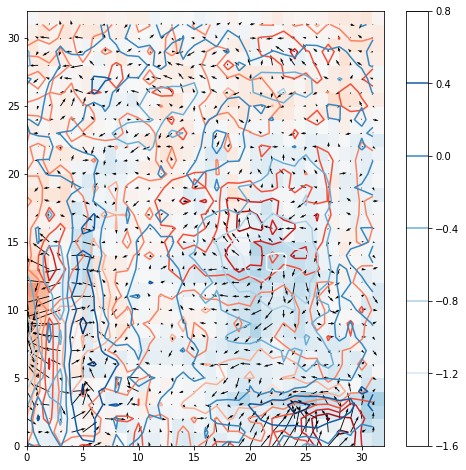

In [43]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(input_img_data[0, :, :, 0], 
               vmin=-3, vmax=3, cmap="RdBu_r")
plt.contour(input_img_data[0, :, :, 1], cmap="Reds")
plt.contour(input_img_data[0, :, :, 2], cmap="Blues")

#plt.contour(gaussian_filter(input_img_data[0, :, :, 3], 1), vmin=-4, vmax=4, cmap="Greens")
plt.colorbar()
plt.quiver(input_img_data[0, :, :, 3], input_img_data[0, :, :, 4])

(array([  4.,  26.,  56.,  79.,  64.,  75.,  55.,  15.,   8.,   2.]),
 array([-0.35487118, -0.26709717, -0.17932316, -0.09154915, -0.00377514,
         0.08399887,  0.17177289,  0.2595469 ,  0.34732091,  0.43509492,
         0.52286893]),
 <a list of 10 Patch objects>)

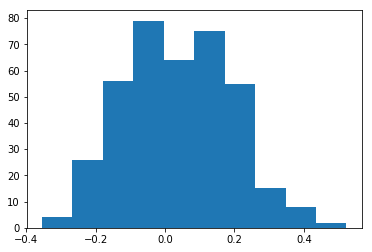

In [44]:
plt.hist(conv_model.layers[-2].get_weights()[0])

In [82]:
conv_model.layers[-3].output[:, top_neurons]

array([ 52, 191, 337,  60, 308,  20, 141, 311, 371, 140])

In [108]:
out_diff = K.mean((conv_model.layers[-3].output[0, 26] - 2) ** 2)
grad = K.gradients(out_diff, [conv_model.input])[0]
grad /= K.maximum(K.sqrt(K.mean(grad ** 2)), K.epsilon())
iterate = K.function([conv_model.input, K.learning_phase()], 
                         [out_diff, grad])
#input_img_data = np.random.normal(scale=0.1, size=(1, 32, 32, len(in_vars)))
input_img_data_neuron = np.zeros((1, 32, 32, len(in_vars)))
for i in range(50):
    out_loss, out_grad = iterate([input_img_data_neuron, 0])
    input_img_data_neuron -= out_grad * 0.01
    print(out_loss, out_grad.max())

2.49693 7.17921
2.14416 7.22552
1.77462 7.11836
1.43088 8.02058
1.12998 8.45579
0.854363 8.27417
0.613636 8.16822
0.407435 8.07481
0.231965 8.61573
0.0604794 6.80004
0.00232997 7.19674
0.0524063 6.75868
0.000773561 7.60285
0.0463118 7.71862
0.000445926 6.86044
0.0431581 7.85443
0.000299435 6.63252
0.0412618 8.42707
0.000231196 5.79025
0.0406484 8.38631
0.000160615 5.69415
0.0398972 8.50517
0.000128853 5.65301
0.0389771 8.51771
0.000120699 5.46546
0.0384323 8.51791
0.000101998 5.36569
0.0383238 8.48891
8.29525e-05 5.55526
0.038179 8.76535
7.28447e-05 5.30501
0.0380216 8.72536
7.36118e-05 5.27217
0.0378584 8.72353
7.69796e-05 5.20309
0.0378314 8.69328
6.97845e-05 5.20265
0.0379604 8.94418
6.58812e-05 5.19329
0.0380035 8.77743
6.52172e-05 5.17641
0.0380096 8.98081
6.33136e-05 5.17641
0.0380337 8.78703
6.27608e-05 5.17641
0.0380262 8.7911
6.23384e-05 5.17641
0.0380158 8.7911
6.19175e-05 5.17641
0.0380054 8.7923


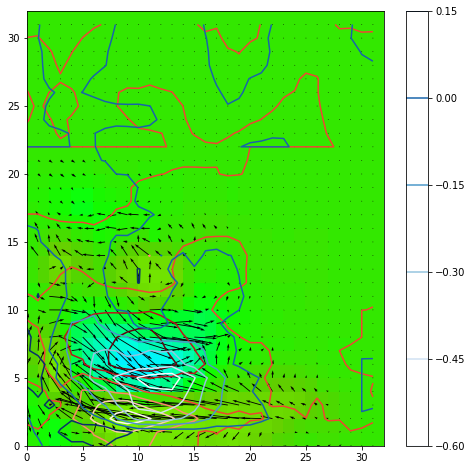

In [110]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(input_img_data_neuron[0, :, :, 0] * scaling_values.loc[0, "std"] + scaling_values.loc[0, "mean"], 
               vmin=-10, vmax=80, cmap="gist_ncar")
plt.contour(input_img_data_neuron[0, :, :, 1], cmap="Reds")
plt.contour(input_img_data_neuron[0, :, :, 2], cmap="Blues")

#plt.contour(gaussian_filter(input_img_data[0, :, :, 3], 1), vmin=-4, vmax=4, cmap="Greens")
plt.colorbar()
plt.quiver(input_img_data_neuron[0, :, :, 3], input_img_data_neuron[0, :, :, 4])

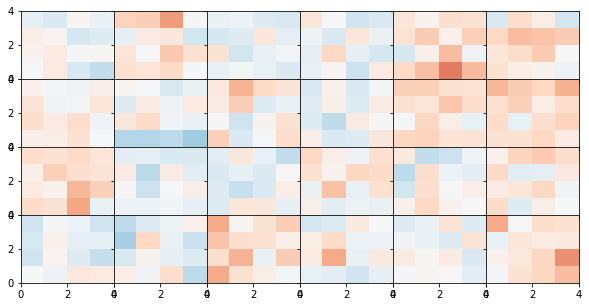

In [55]:
weight_panels = conv_model.layers[-2].get_weights()[0].reshape((4,4, 24))
fig, axes = plt.subplots(4,6, figsize=(10, 5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0,hspace=0)
for a, ax in enumerate(axes.ravel()):
    ax.pcolormesh(weight_panels[:, :, a], vmin=-1, vmax=1, cmap="RdBu_r")

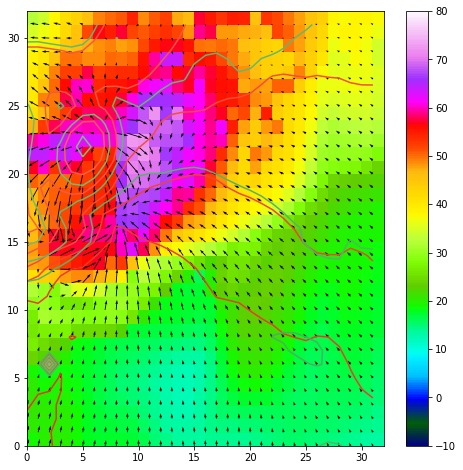

In [57]:
rot_ex = max_rot.argmax()
plt.figure(figsize=(8, 8))
plt.pcolormesh(all_in_data[rot_ex, :, :, 0], cmap="gist_ncar", vmin=-10, vmax=80)
plt.colorbar()
plt.contour(all_in_data[rot_ex, :, :, 1] - 273, np.arange(0, 40, 1), cmap="Reds", vmin=0, vmax=40)
plt.contour(all_in_data[rot_ex, :, :, 2] - 273, np.arange(0, 40, 1), cmap="Greens", vmin=0, vmax=40)

plt.quiver(all_in_data[rot_ex, :, :, 3], all_in_data[130982, :, :, 4])

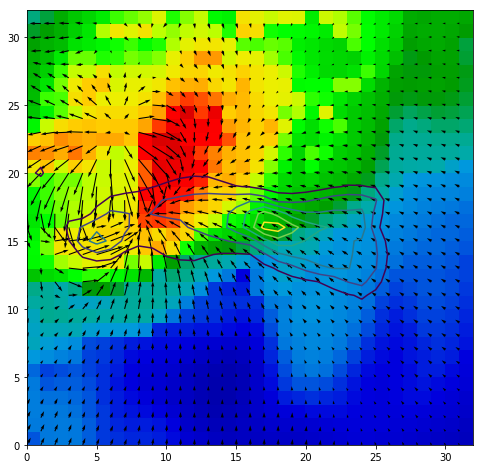

In [149]:
plt.figure(figsize=(8, 8))
plt.pcolormesh(all_in_data[130982, :, :, 0], cmap="nipy_spectral", vmin=0, vmax=80)
#plt.contour(all_in_data[130982, :, :, 1], cmap="Blues")
#plt.contour(all_in_data[130982, :, :, 2] - 273, np.arange(0, 40, 1), cmap="Reds", vmin=0, vmax=40)
#plt.contour(all_in_data[130982, :, :, 3] - 273, np.arange(0, 40, 1), cmap="Greens", vmin=0, vmax=40)
plt.contour(all_out_data[130982, :, :, 0])
plt.quiver(norm_in_data[130982, :, :, 4], norm_in_data[130982, :, :, 5])